# Density estimation

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [191]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import scipy.special as spec
import urllib.request
import os.path
import zipfile
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, green, blue = sns.color_palette('Set1', 3)
np.random.seed(847)

Some of the presented exercises follow the book [IPython Cookbook](http://ipython-books.github.io/cookbook/) by [Cyrille Rossant](http://cyrille.rossant.net/).

https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py

https://janvdvegt.github.io/2017/06/07/Kernel-Mixture-Networks.html

http://ruishu.io/2018/03/14/vae/

# Density estimation

IS...

# Histograms

We use transplant survival data (originally from *Miller, R. (1976). Least squares regression with censored dara. Biometrica, 63 (3). 449-464*). This data contains the survival time after receiving a heart transplant.

In [81]:
df = pd.read_csv('../data/heart.csv')
X = df['survival']
df.head()

,survival
0,15.0
1,3.0
2,624.0
3,46.0
4,127.0


We start by plotting the survival data for each patient, by descending survival, and the histogram of the survival data.

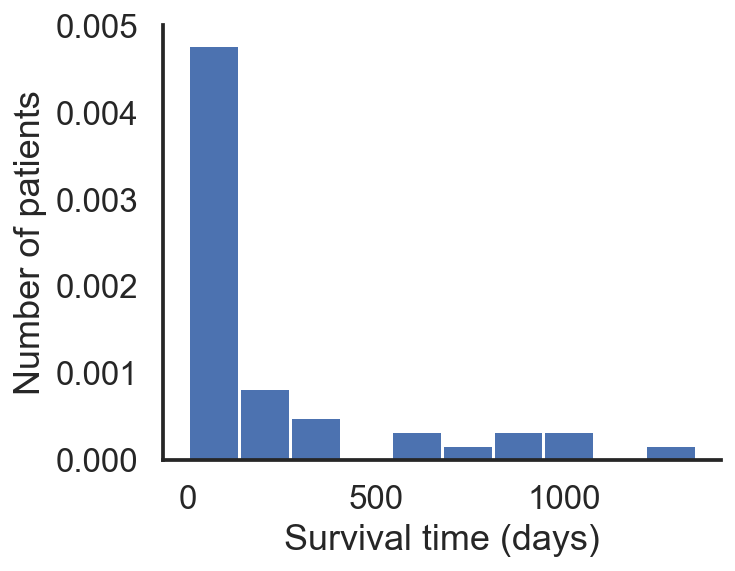

In [82]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(X, bins=10, density=True)
ax.set(xlabel='Survival time (days)', ylabel='Number of patients')
sns.despine()

The number (or width) of bins can be an important factor.

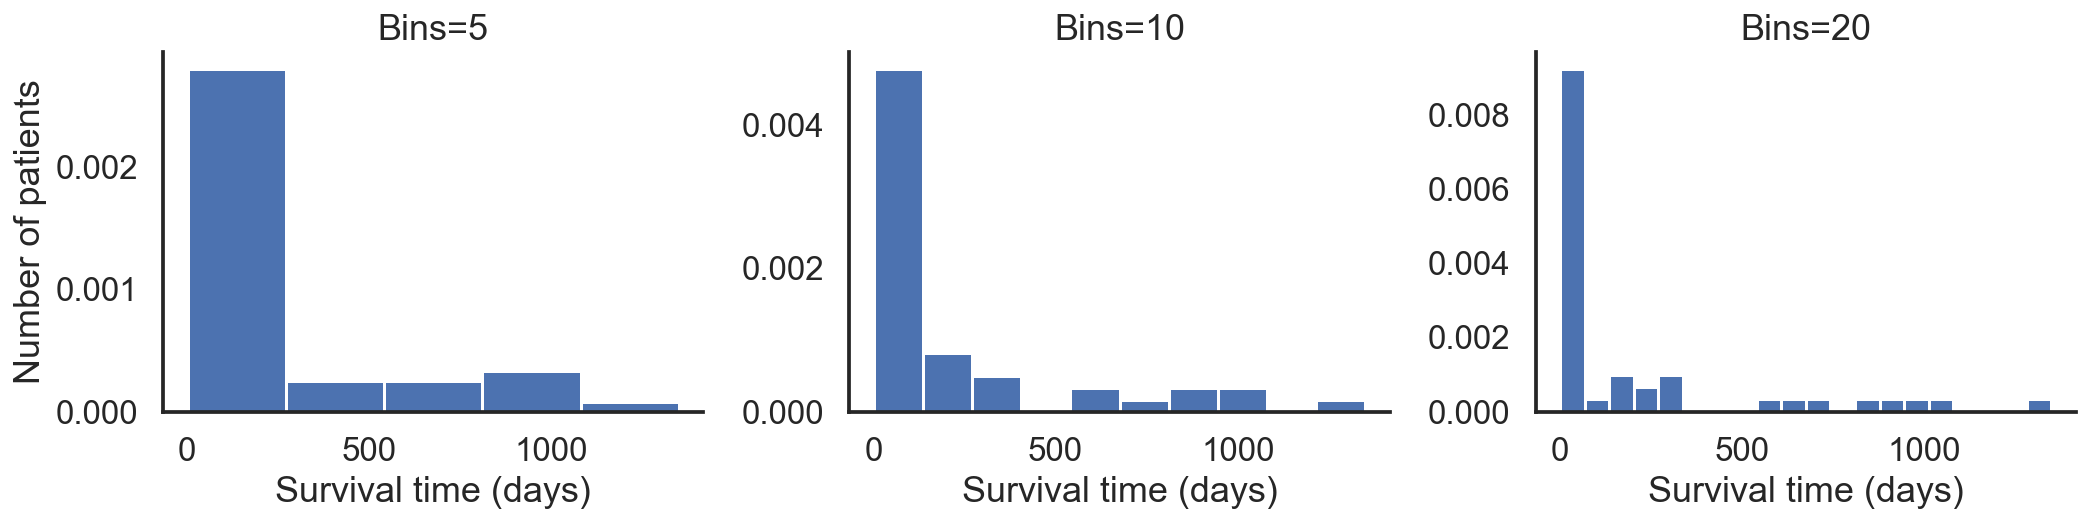

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for bins, ax in zip([5, 10, 20], axes.flat):
    ax.hist(X, bins=bins, density=True)
    ax.set(title='Bins={}'.format(bins), xlabel='Survival time (days)')
axes[0].set(ylabel='Number of patients')
fig.tight_layout()
sns.despine()

# Parametric estimation

If we assume that the data is distributed according to a known distribution, we can infer the parameters of that distributions, e.g. using MLE or MCMC.
We did such an example early in the course when we had some Poisson-distributed data.

It seems that the histogram is decreasing rapidly (this is data from the 1970s), so we will try to fit an exponential distribution to the data.

If we assume the data is exponentially distributed
$$
X \sim \mathit{Exp}(\lambda)
$$
then the [likelihood function](https://en.wikipedia.org/wiki/Exponential_distribution#Parameter_estimation) is
$$
\mathcal{L}(\lambda \mid X) = P(X \mid \lambda) = \\
\prod_{i=1}^{n} \lambda \exp \left(-\lambda x_{i}\right) = \\
\lambda^{n} \exp \left(-\lambda \sum_{i=1}^{n} x_{i}\right)
$$

and therefore the log-likelihood is
$$
\log\mathcal{L}(\lambda \mid X) = n \log\lambda - \lambda \sum_{i=1}^{n} x_{i}.
$$
Taking the derivative,
$$
\frac{d \log\mathcal{L}(\lambda \mid X)}{d \lambda} = \frac{n}{\lambda} - \sum_{i=1}^{n} x_{i}.
$$
Finally, solving for 0, 
$$
\frac{d \log\mathcal{L}(\lambda \mid X)}{d \lambda} = 0 \Rightarrow \\
\frac{n}{\widehat \lambda} - \sum_{i=1}^{n}  = 0 \Rightarrow \\
\widehat\lambda = \frac{n}{\sum_{i=1}^{n}} \Rightarrow \\
\widehat\lambda = \frac{1}{\bar{X}},
$$
where $\bar{X}$ is the sample average.

The exponential distribution in SciPy is parameterized by a bit differently from the usual way, as $\mathit{Exp}(1, 1/\lambda)$, so:

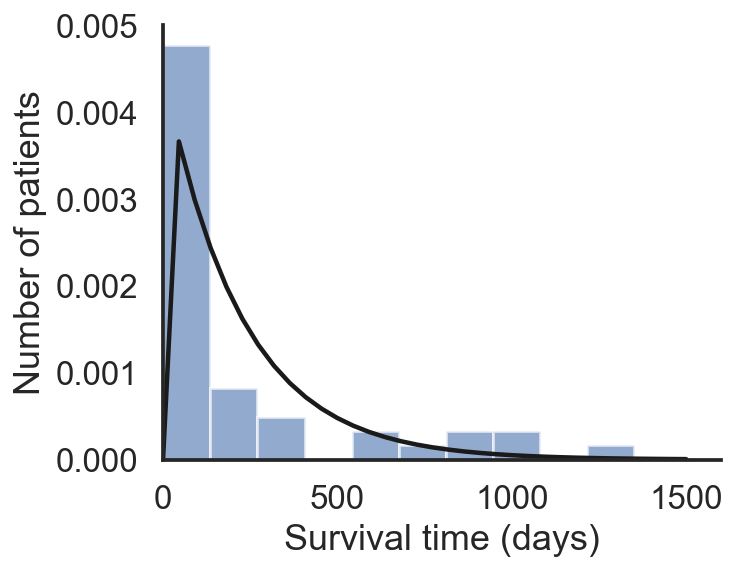

In [84]:
expon = scipy.stats.expon(1, X.mean())

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(X, bins=10, density=True, alpha=0.6)

xticks = ax.get_xticks()
xrange = np.linspace(min(xticks), max(xticks), len(X))
pdf = expon.pdf(xrange)
ax.plot(xrange, pdf, color='k')
ax.set(xlabel='Survival time (days)', ylabel='Number of patients', xlim=(0, None))
sns.despine()

SciPy has builtin functions to estimate probability distributions using MLE.
We do this using the `scipy.stats.expon` class which has a `fit` class method (as do all the continous distributions, but no the discrete).

params (1.0, 222.2888888888889)


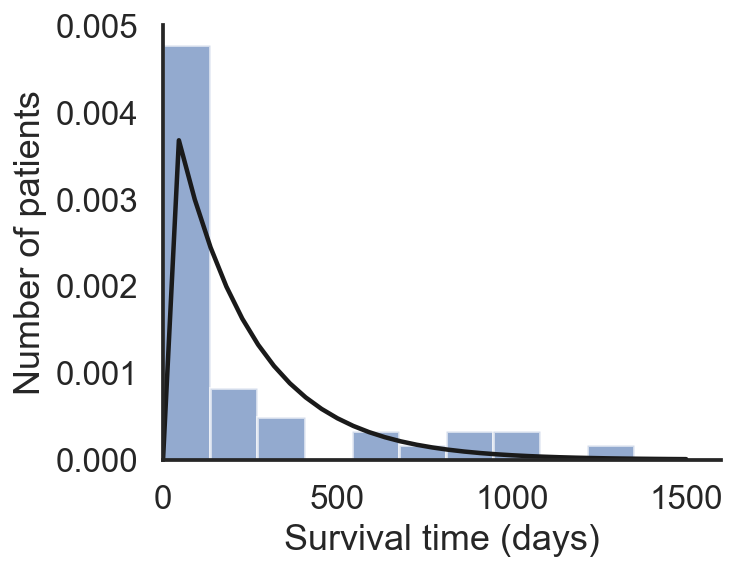

In [85]:
params = scipy.stats.expon.fit(X)
print('params', params)

expon = scipy.stats.expon(*params)

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(X, bins=10, density=True, alpha=0.6)
ax.plot(xrange, expon.pdf(xrange), color='k')
ax.set(xlabel='Survival time (days)', ylabel='Number of patients', xlim=(0, None))
sns.despine()

If all we want is to plot the histogram with a fitted distribution, we can just use `seaborn.distplot`:

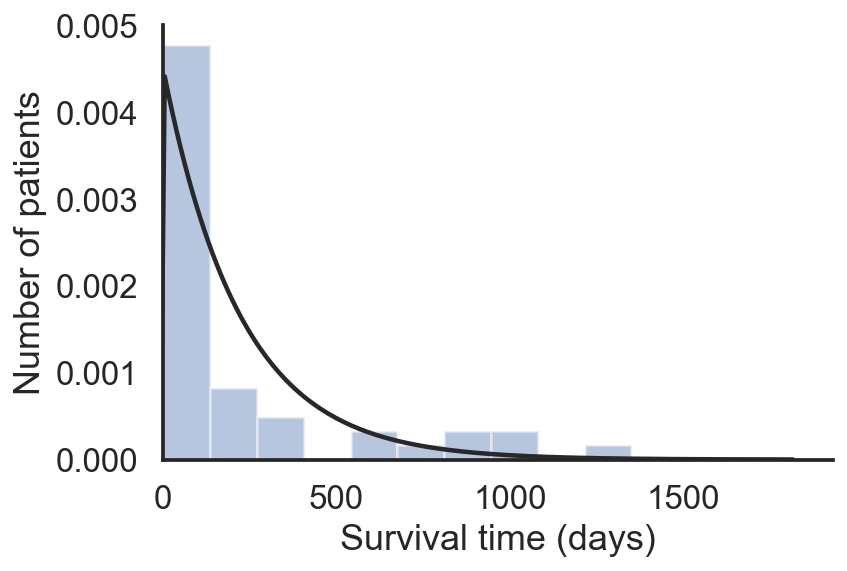

In [86]:
ax = sns.distplot(X, bins=10, kde=False, fit=scipy.stats.expon)
ax.set(xlabel='Survival time (days)', ylabel='Number of patients', xlim=(0, None))
sns.despine()

This doesn't look that good. A statistical test for the fit of the distribution to the data (a statistical quantification to the statement "this doesn't look that good") can be done with the [Kolmogorov-Smirnov goodness of fit test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test) implemented in the `scipy.stats.kstest` function. The null hypothesis in this case is that the data came from the estimated exponential distribution.

In [87]:
D, p = scipy.stats.kstest(X, expon.cdf)
print("Exponential distribution")
print("P-value: {0:.2g}, reject null hypothesis: {1}".format(p, p < 0.05))

Exponential distribution
P-value: 8.6e-06, reject null hypothesis: True


Indeed, we reject the null hypothesis - the exponential distribution is unlikely for this dataset.

## Exercise

Let's try a different distribution, the [fatigue life distribution](https://en.wikipedia.org/wiki/Birnbaum%E2%80%93Saunders_distribution), used extensively in reliability applications to model failure times.

Fit the distribution to the data, test it with the `kstest`, and plot it with the data and the exponential distribution for comparison.

**Note** the fatigue-life distribution has three parameters whereas the exponential distribution has two, so we should probably use another statistical method to decide on the correct model, such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

# Kernel density estimation

Sometimes we don't have an idea as to what is the *real* distribution of the data.
In these cases we can perform non-parameteric estimation to fit an arbitrary family of function to the data distribution. 

Here, we use a [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE).
For example, Seaborn will automatically use KDE with a gaussian kernel if we use `distplot`:

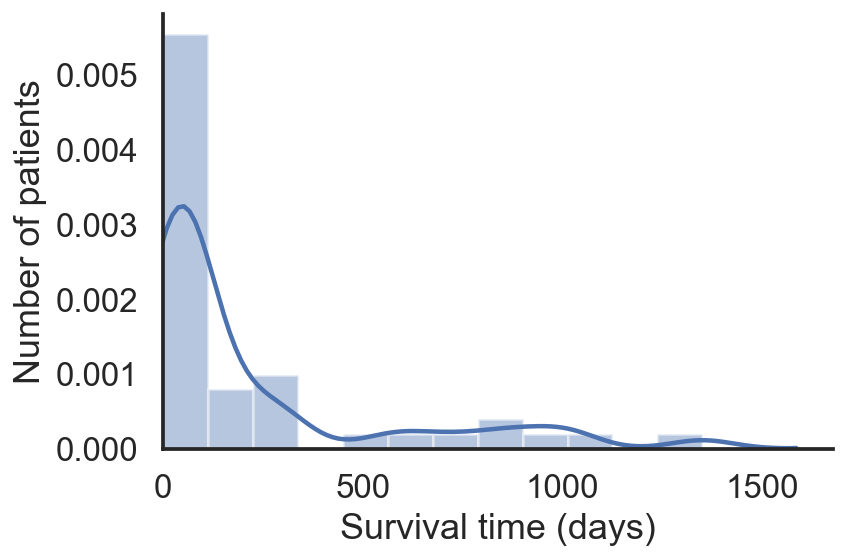

In [88]:
ax = sns.distplot(X)
ax.set(xlabel='Survival time (days)', ylabel='Number of patients', xlim=(0, None))
sns.despine()

How is this done?

For a histogram, 
- the horizontal axis is divided into bins that cover the range of the data.
- (here, we have 6 bins each of width 2, from -4 to 8.)
- when a value falls inside a bin, we place a box of height `1/(bins*width)` (here 1/12~0.83).
- if more than one value falls inside the same bin, we stack the boxes on top of each other.

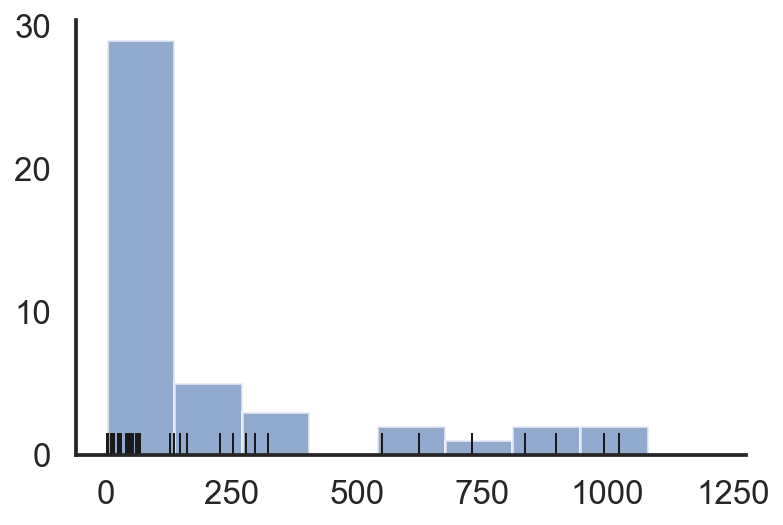

In [89]:
n = X.size
nbins = 10
width = (X.max() - X.min()) / nbins
bins = np.arange(X.min(), X.max(), width)
hist = np.array([
    ((bin0 <= X) & (X < bin1)).sum() 
    for bin0, bin1 
    in zip(bins[:-1], bins[1:])
])

ax = sns.rugplot(X, color='k')
ax.bar(bins[:-1], hist, width=width, align='edge', alpha=0.6)
sns.despine()

Again, we can do this automatically with `seaborn.distplot`.

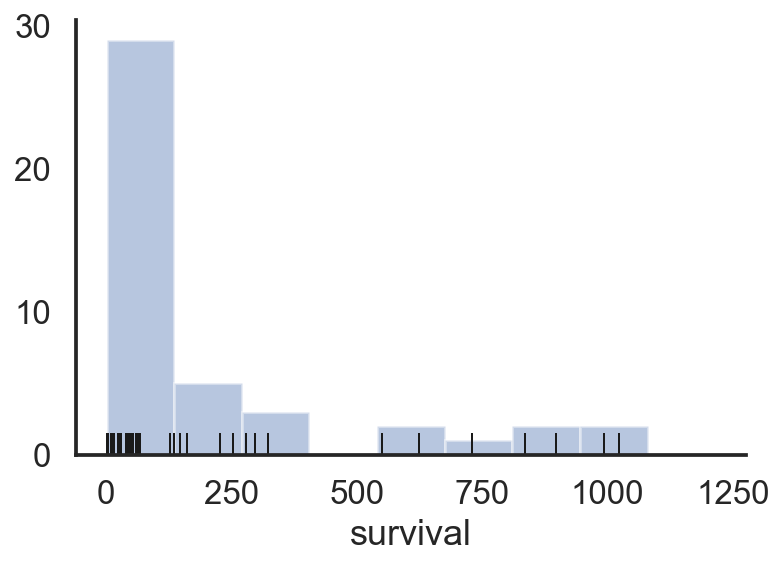

In [90]:
ax = sns.distplot(X, bins, kde=False, rug=True, rug_kws=dict(color='k'))
sns.despine()

For the kernel density estimate, 
- we place a (normal) kernel with variance $\sigma^2$ (red lines) on each of the values `X[i]`.
- the kernels are summed to make the kernel density estimate (black line).

$\sigma$ is a bandwith hyper-parameter.

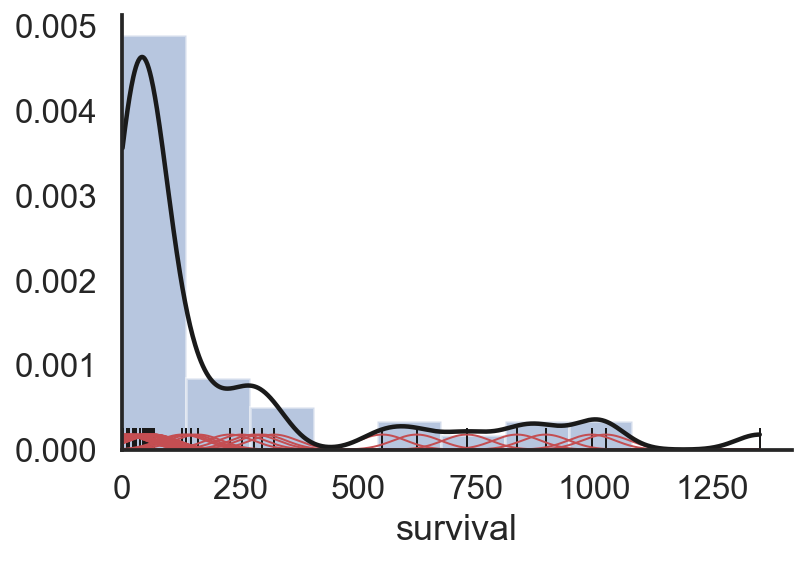

In [91]:
# same histogram as above
ax = sns.distplot(X, bins, kde=False, rug=True, norm_hist=True, rug_kws=dict(color='k'))

σ = 50
xrange = np.linspace(X.min(), X.max(), 1000)

total_kde = np.zeros(xrange.size) # sum all kernels here
for X_i in X:
    norm = scipy.stats.norm(X_i, σ)
    kde_i = norm.pdf(xrange)/n # normal (Gaussian) kernel
    total_kde += kde_i
    ax.plot(xrange, kde_i, color='r', lw=1) # plot each kernel
ax.plot(xrange, total_kde, color='k') # plot kernel sums
ax.set(xlim=(0, None))
sns.despine()

Now that we know how it works we can just use Seaborn:

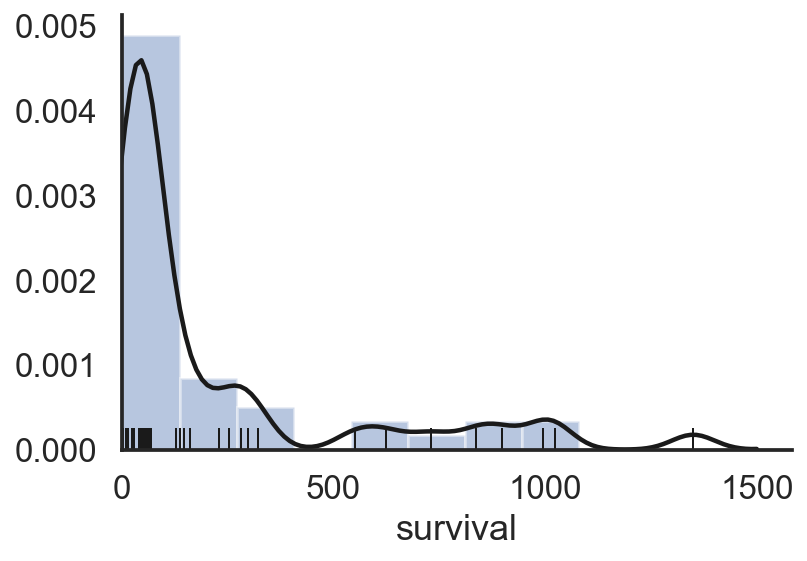

In [92]:
ax = sns.distplot(X, bins, kde=True, rug=True, norm_hist=True, 
                  rug_kws=dict(color='k'), kde_kws=dict(bw=σ, color='k'))
ax.set(xlim=(0, None))
sns.despine()

Note that the bandwidth parameter, just like the bin width of a histogram, matters.

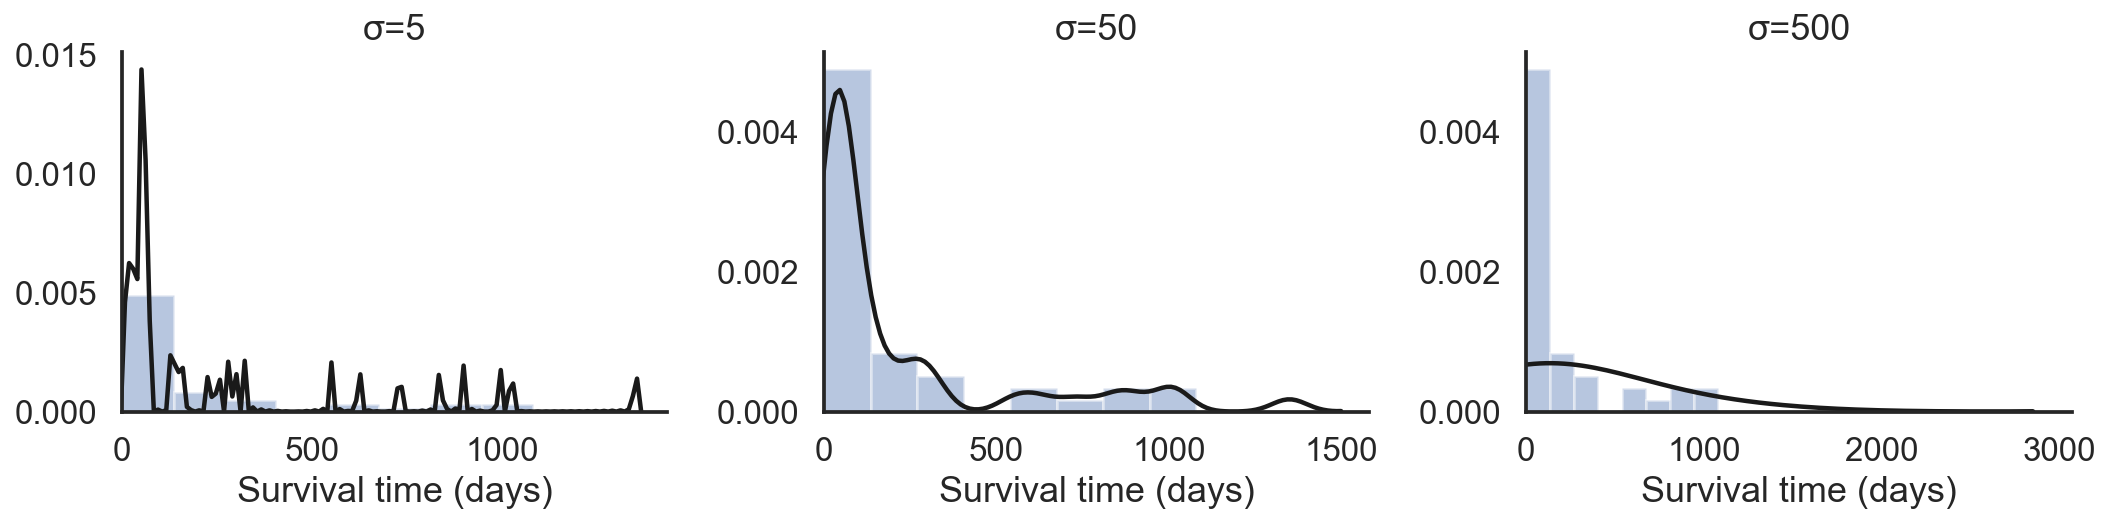

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for σ, ax in zip([5, 50, 500], axes.flat):
    sns.distplot(X, bins, norm_hist=True, kde_kws=dict(bw=σ, color='k'), ax=ax)
    ax.set(title='σ={}'.format(σ), xlabel='Survival time (days)', xlim=(0, None))
fig.tight_layout()
sns.despine()

### SciPy

We will use SciPy's KDE, essentially provides us with a density function!

The bandwith is automatically determined, see the documentation.

In [94]:
kde = scipy.stats.gaussian_kde(X)
kde

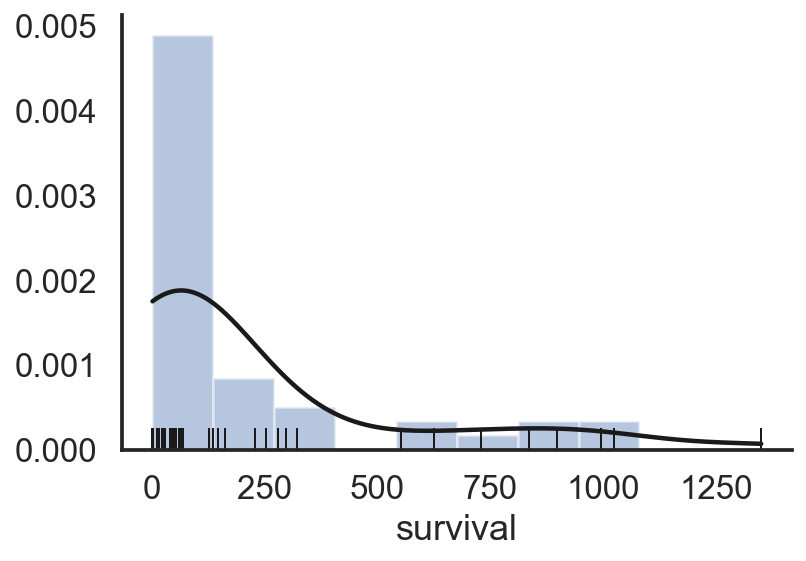

In [16]:
ax = sns.distplot(X, bins, kde=False, rug=True, norm_hist=True, rug_kws=dict(color='k'))
ax.plot(xrange, kde(xrange), color='k')
sns.despine()

We can use the KDE function to estimate the density of a survival time we have not observed:

In [17]:
print("P(X=400) = {:.2g}".format(kde(400)[0]))

P(X=400) = 0.00044


We can also generate new data:

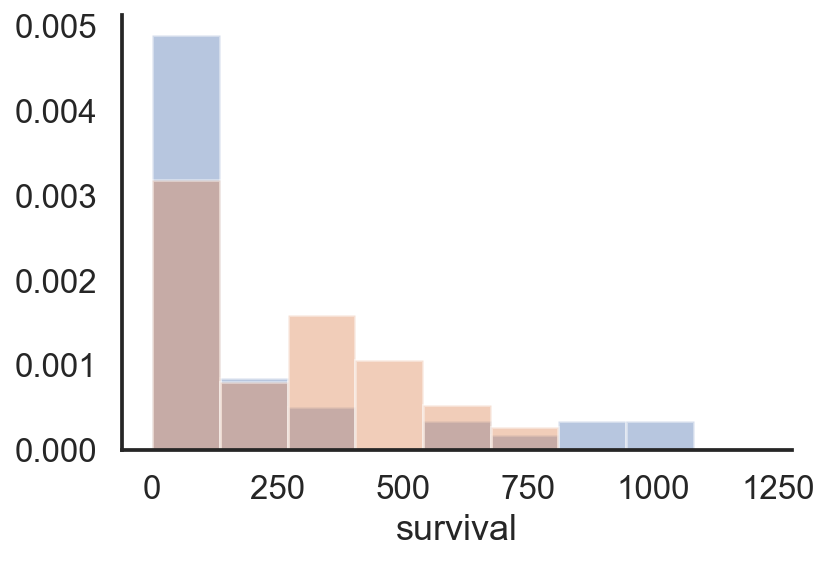

In [95]:
X_kde = kde.resample(X.size)

ax = sns.distplot(X, bins, kde=False, norm_hist=True, label='X')
sns.distplot(X_kde, bins, kde=False, norm_hist=True, label="X'", ax=ax)
sns.despine()

## Scikit-learn

[Scikit-learn](https://scikit-learn.org/stable/modules/density.html) also has a KDE estimator that supports additional kernels.

In [18]:
from sklearn.neighbors import KernelDensity

# scikit-learn wants X as 2D 
X = X.values.reshape((-1, 1))

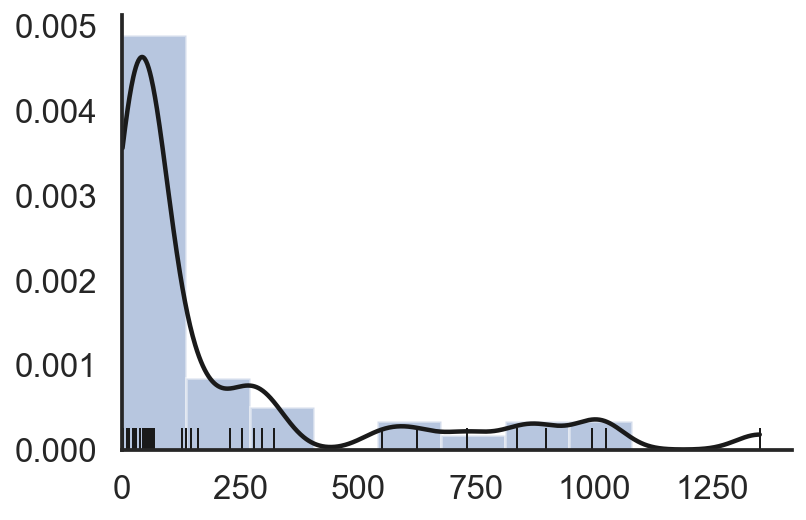

In [33]:
kde = KernelDensity(kernel='gaussian', bandwidth=50).fit(X)

ax = sns.distplot(X, bins, kde=False, rug=True, norm_hist=True, rug_kws=dict(color='k'))
logpdf = kde.score_samples(xrange.reshape((-1, 1))) # returns log-density
ax.plot(xrange, np.exp(logpdf), 'k')
ax.set(xlim=(0, None))
sns.despine()

Let's compare several kernels.

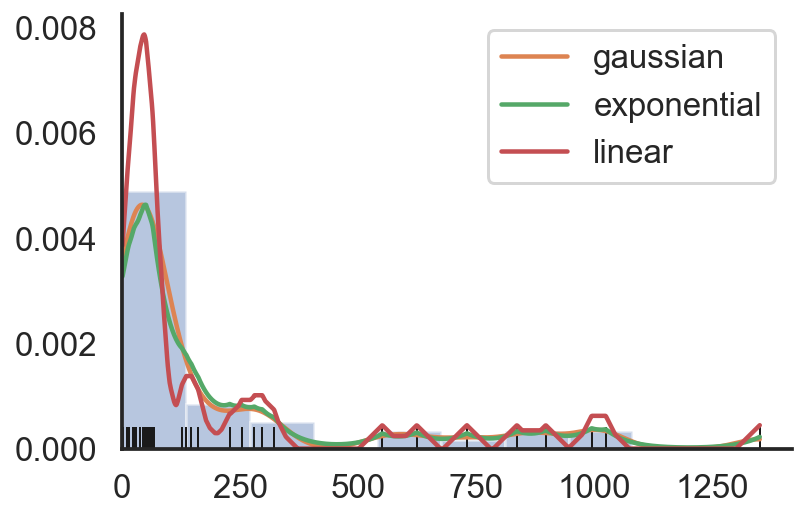

In [39]:
ax = sns.distplot(X, bins, kde=False, rug=True, norm_hist=True, rug_kws=dict(color='k'))

for kernel in ['gaussian', 'exponential', 'linear']:
    kde = KernelDensity(kernel=kernel, bandwidth=50).fit(X)
    logpdf = kde.score_samples(xrange.reshape((-1, 1))) # returns log-density
    ax.plot(xrange, np.exp(logpdf), label=kernel)
ax.set(xlim=(0, None))
ax.legend()
sns.despine()

Here, the Gaussian and exponential seem like the best choice.

Scikit-learn's KDE estimator also allows us to **sample** from the distribution estimated by the density.

In [66]:
kde = KernelDensity(kernel='gaussian', bandwidth=50).fit(X)
X_sim = kde.sample(100)

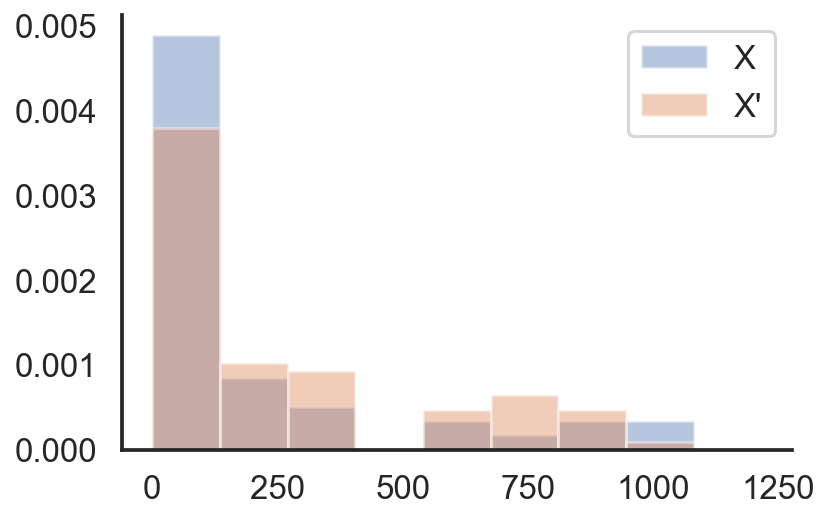

In [71]:
ax = sns.distplot(X, bins, kde=False, norm_hist=True, label='X')
sns.distplot(X_sim, bins, kde=False, norm_hist=True, ax=ax, label='X\'')
ax.legend()
sns.despine()

## 2D kernel density estimation

We'll now use KDE to estimate the density of a spatial empirical distribution.
We look at the geographical locations of tropical [cyclones](https://en.wikipedia.org/wiki/Cyclone) (sometimes known as hurricanes, typhoons, or tornados) from 1848 to 2013, based on data provided by the NOAA, the US' National Oceanic and Atmospheric Administration.

We'll need the [CatroPy](http://scitools.org.uk/cartopy/) package, which is a *Matplotlib* add-on that displays maps.

In [96]:
import cartopy.crs as ccrs

We load the storms data set from the [IPython Cookbook data repo](https://github.com/ipython-books/cookbook-data).

In [97]:
url = 'https://github.com/ipython-books/cookbook-data/raw/master/storms.zip'
filename = '../data/storms.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
print("Data file exists:", os.path.exists(filename))

zf = zipfile.ZipFile(filename)
with zf.open('data/Allstorms.ibtracs_wmo.v03r05.csv') as f:
    df = pd.read_csv(f)
df.head()

Data file exists: True


,Serial_Num,Season,Num,Basin,Sub_basin,Name,ISO_time,Nature,Latitude,Longitude,Wind(WMO),Pres(WMO),Center,Wind(WMO) Percentile,Pres(WMO) Percentile,Track_type
0,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-11 06:00:00,NR,-8.6,79.8,0.0,0.0,reunion,-100.0,-100.0,main
1,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-12 06:00:00,NR,-9.0,78.9,0.0,0.0,reunion,-100.0,-100.0,main
2,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-13 06:00:00,NR,-10.4,73.2,0.0,0.0,reunion,-100.0,-100.0,main
3,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-14 06:00:00,NR,-12.8,69.9,0.0,0.0,reunion,-100.0,-100.0,main
4,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-15 06:00:00,NR,-13.9,68.9,0.0,0.0,reunion,-100.0,-100.0,main


The interesting columns for us are:

In [98]:
df = df[['Serial_Num', 'Season', 'Basin', 'Latitude', 'Longitude']]
df.head()

,Serial_Num,Season,Basin,Latitude,Longitude
0,1848011S09080,1848,SI,-8.6,79.8
1,1848011S09080,1848,SI,-9.0,78.9
2,1848011S09080,1848,SI,-10.4,73.2
3,1848011S09080,1848,SI,-12.8,69.9
4,1848011S09080,1848,SI,-13.9,68.9


The dataset contains information about most storms since 1848. A single storm may appear multiple times across several consecutive days. We group the data by `Serial_num` (storm identifier) and aggregate to get the average location of every storm:

In [99]:
dfs = df.groupby('Serial_Num')
pos = dfs[['Latitude', 'Longitude']].mean()
pos.head()

,Latitude,Longitude
Serial_Num,,
1848011S09080,-15.918182,71.854545
1848011S15057,-24.116667,52.016667
1848061S12075,-20.528571,65.342857
1851080S15063,-17.325000,55.400000
1851080S21060,-23.633333,60.200000


We plot a world map with an equi-rectangular projection called Plate Carree ([let's not get started on map projection, ok?](https://www.youtube.com/watch?v=QMlp8BeBJgg))

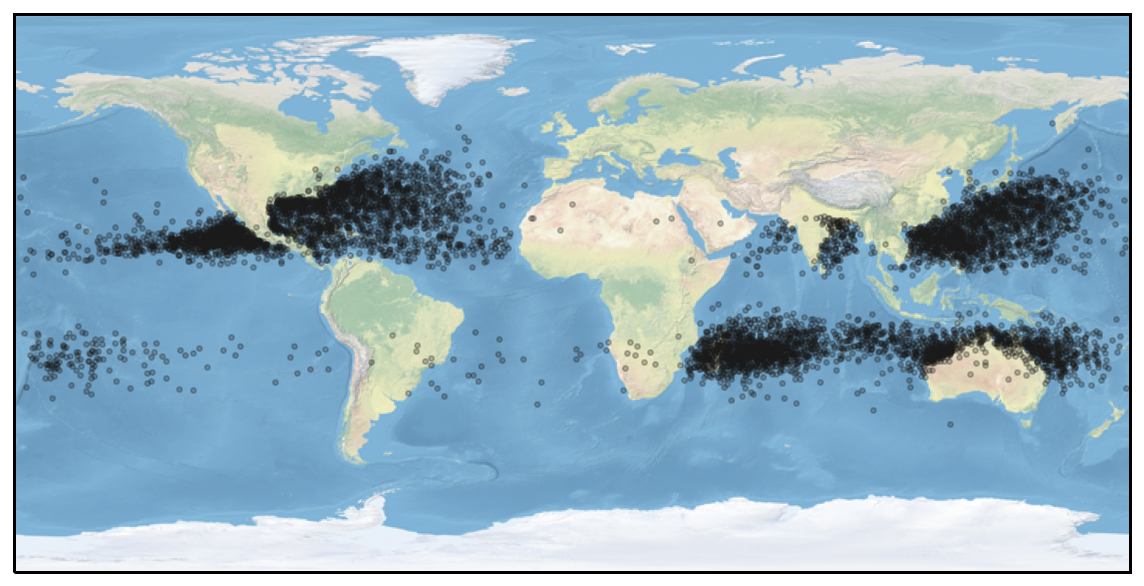

In [100]:
# create the projections and the axes
crs = ccrs.PlateCarree()
ax = plt.axes(projection=crs)
# plot the map
ax.stock_img()
# get the positions and plot the markers
x = pos['Longitude'].values
y = pos['Latitude'].values
ax.plot(x, y, '.k', markersize=5, alpha=0.25)

# resize image
ax.figure.set_figwidth(10)
ax.figure.set_figheight(6)

Indeed we see that the storms mostly occur around the tropics, mostly the coasts of central america, madagascar, northrn austrialia, southeast asia, and Japan.

To estimate the storm distribution, we first need to transform the storms positions from geodetic coordinates (longtitude and latitude) to the map's coordinates (plate carree).

In [101]:
geo = ccrs.Geodetic()
h = geo.transform_points(crs, x, y)[:, :2].T
h.shape

(2, 6940)

Now we perform the density estimation using `scipy.stats.gaussian_kde`, which returns a Python function which estimates the density function.

In [102]:
kde = scipy.stats.gaussian_kde(h)

We'll now apply this `kde` function to a 2D grid of points on the map.
We do this with `meshgrid`.

We set the north-south resolution to be `k` and the east-west to be `2k`, and get the corners of the grid from the map axes.

In [53]:
k = 100
x0, x1, y0, y1 = ax.get_extent()
xrange = np.linspace(x0, x1, 2 * k)
yrange = np.linspace(y0, y1, k)

`meshgrid` returns a list of two `(k, 2k)` arrays, the first for the x coordinates of each point in the grid, and the second for the y coordinates of each point in the grid.

In [54]:
tx, ty = np.meshgrid(xrange, yrange)
tx.shape, ty.shape

((100, 200), (100, 200))

We reshape the grid for the `kde` function, which expects one or many points.

In [55]:
mesh = np.vstack((tx.ravel(), ty.ravel()))
mesh.shape, 2*k**2

((2, 20000), 20000)

We evaluate the `kde` function on the grid points, and reshape the result back to `(2, 2k)`.

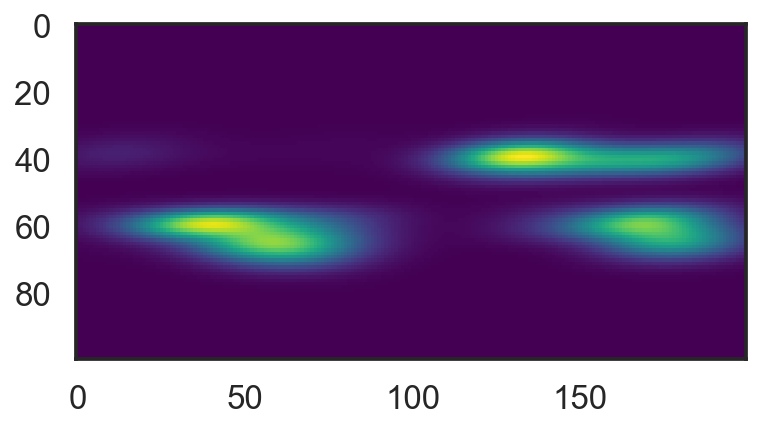

In [56]:
v = kde(mesh).reshape((k, 2 * k))
plt.imshow(v, cmap='viridis');

Before displaying the KDE heatmap on the map, we need to use a special colormap with a transparent channel.
This will allow us to superimpose the heatmap on the stock map image.

In [57]:
# https://stackoverflow.com/a/37334212/1595060
cmap = plt.get_cmap('Reds')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
my_cmap = mpl.colors.ListedColormap(my_cmap);

Finally, we plot the density map on (or rather above) the geographical map.

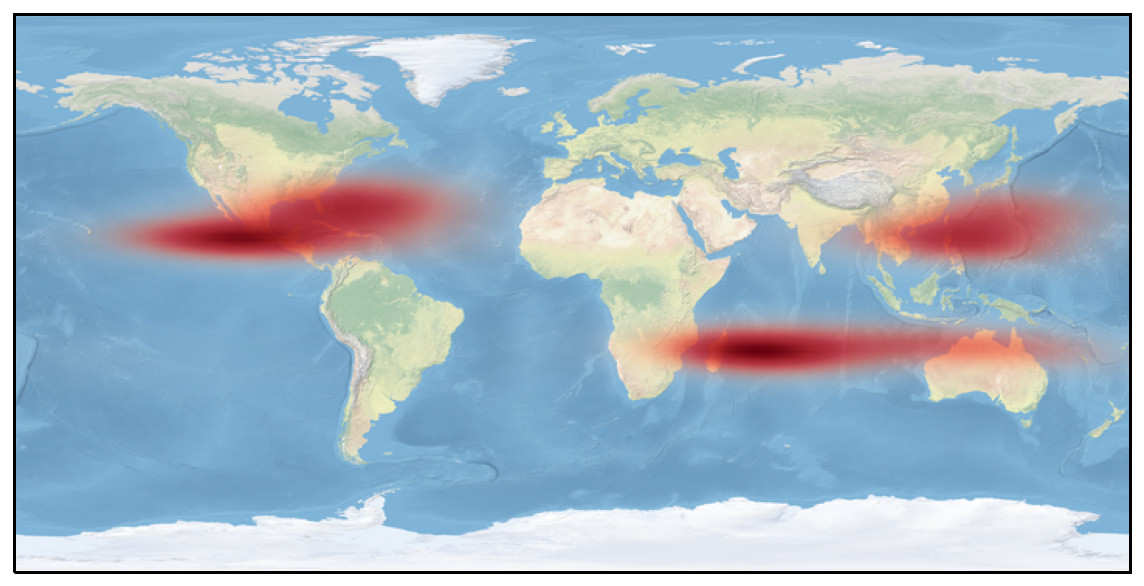

In [58]:
ax = plt.axes(projection=crs)
ax.stock_img()
ax.imshow(v, origin='lower',
         extent=[x0, x1, y0, y1],
         interpolation='bilinear',
         cmap=my_cmap)
ax.figure.set_figwidth(10)
ax.figure.set_figheight(6)

## Exercise

Consider the following random data, drawn from a 2D normal distribution:

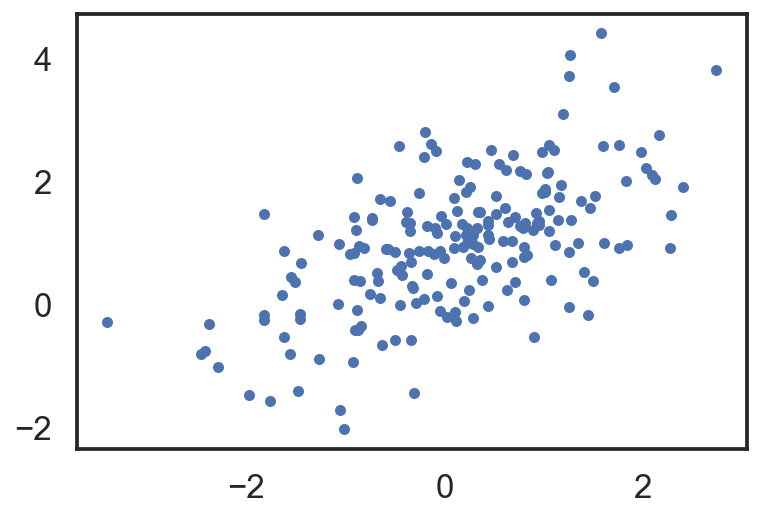

In [64]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
x, y = np.random.multivariate_normal(mean, cov, 200).T

plt.plot(x, y, '.')

Use a KDE approach to estimate and plot the distribution of the random data. 
**Note** if you only want to plot, rather than actually estimate the `kde` function, you can use Seaborn's [`kdeplot`](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html) function. Experiment with the `shade`, `cmap`, and `n_levels` keywords to get aestheticly pleasing results.

## Generative model

We same that we can use KDE to sample from the distribution. This allows us to create a generative model.

Let's build a digits generator.

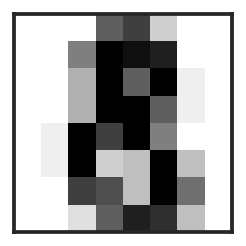

In [114]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

def plot_image(x, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(x.reshape((8, 8)), cmap='gray_r')
    ax.set(xticks=[], yticks=[]);
    
plot_image(X[224])

There are 64 pixels (inputs) per image.

In [127]:
from sklearn.model_selection import GridSearchCV

In [159]:
bandwidths = np.logspace(-1, 1, 20)
grid = GridSearchCV(KernelDensity(), dict(bandwidth=bandwidths))
grid.fit(X)

GridSearchCV(cv=None, error_score=nan,
             estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0,
                                     breadth_first=True, kernel='gaussian',
                                     leaf_size=40, metric='euclidean',
                                     metric_params=None, rtol=0),
             iid='deprecated', n_jobs=None,
             param_grid={'bandwidth': array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [160]:
kde = grid.best_estimator_
print("best bandwidth: {:.2f}".format(grid.best_estimator_.bandwidth))

best bandwidth: 1.83


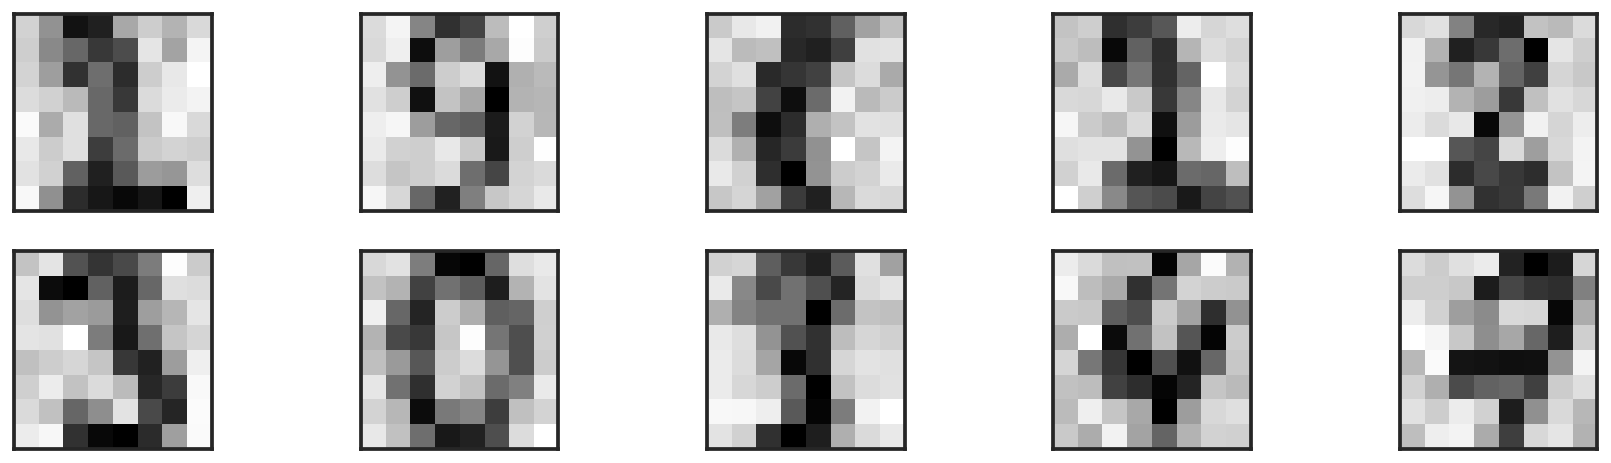

In [161]:
X_kde = kde.sample(10, random_state=0)

fig, axes = plt.subplots(2, 5, figsize=(15, 4))
for x, ax in zip(X_kde, axes.flat):
    plot_image(x, ax)

This looks promising. Can we do better than that? Maybe separate by digit type? Maybe by transforming the digits before doing kernel estimation?

# Mixture model

To illustrate the next approach we will use the [Old Faithful dataset](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat)

In [316]:
filename = '../data/faithful.dat'
df = pd.read_csv(filename, index_col=0)
X = df.values
X1, X2 = X[:,0], X[:,1]
df.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


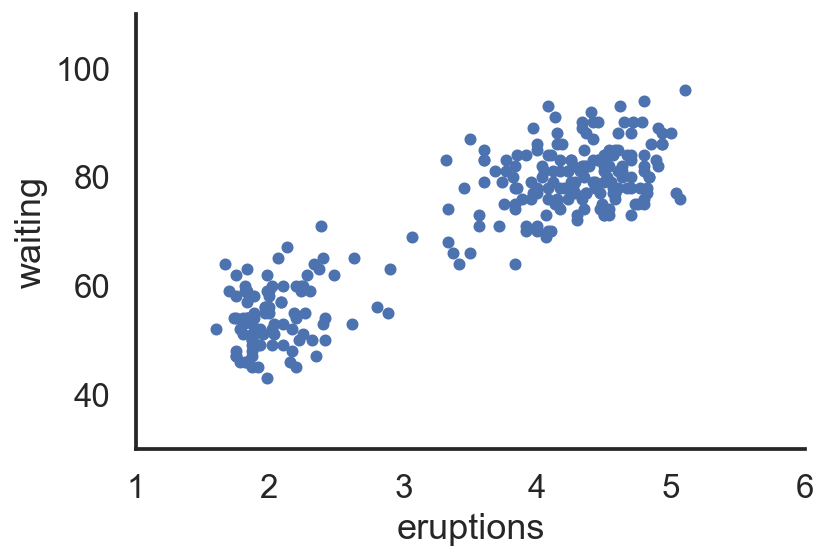

In [319]:
fig, ax = plt.subplots()
ax.scatter(X1, X2, marker='.')
ax.set(xlabel='eruptions', ylabel='waiting', xlim=(1, 6), ylim=(30, 110))
sns.despine()

It seems like there are two distributions here. We can use a KDE approach:

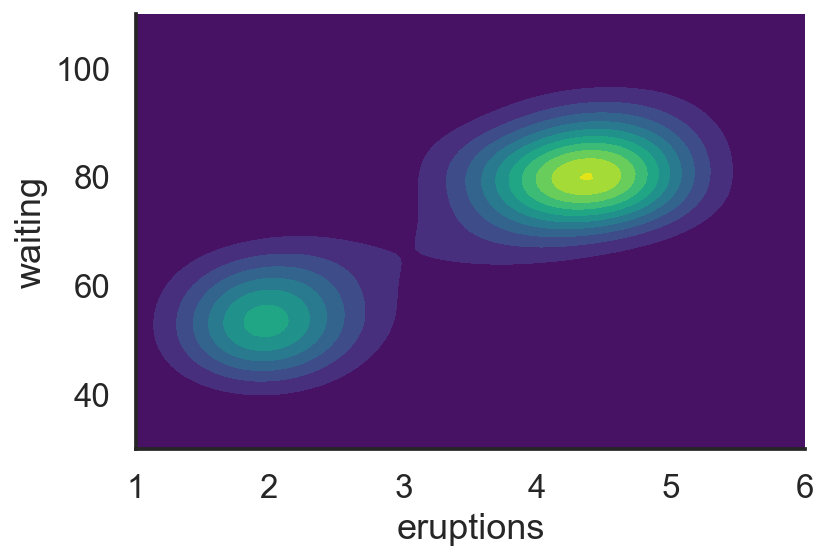

In [320]:
ax = sns.kdeplot(X, shade=True, cmap='viridis', gridsize=100)
ax.set(xlabel='eruptions', ylabel='waiting', xlim=(1, 6), ylim=(30, 110))
sns.despine()

But we can also do a parametric approach.

We assume the following mixture model (a type of a hierarchical model):

$$
X_i \sim \begin{cases}
    N(\mu_1, \rho_1), & Z_i=0 \\
    N(\mu_2, \rho_2), & Z_i=1 \\
\end{cases}
$$
where $Z_i$ is the latent random variable:
$$
Z_i \sim \mathit{Bernoulli}(p)
$$
That is, $X_i$ is distributed according to $N(\mu_1, \rho_1)$ with probability $p$ and according to $N(\mu_2, \rho_2)$ with probability $1-p$.

This is a Gaussian mixture model with two Gaussian. 
Note that here $X_i$ is two-dimensional (`eruptions` and `waiting`), so the Gaussians are multivariate and $\rho$ is a covariance matrix.

Let's fit the model using [Scikit-learn](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html).

In [248]:
from sklearn import mixture

In [321]:
mixed = mixture.GaussianMixture(n_components=2, covariance_type='full')
mixed.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we plot the result.

In [322]:
erup_range = np.linspace(1, 6)
wait_range = np.linspace(30, 110)
erup_mesh, wait_mesh = np.meshgrid(erup_range, wait_range)
X_ = np.array([erup_mesh.ravel(), wait_mesh.ravel()]).T
density = np.exp(mixed.score_samples(X_))
density = density.reshape((erup_range.size, wait_range.size))

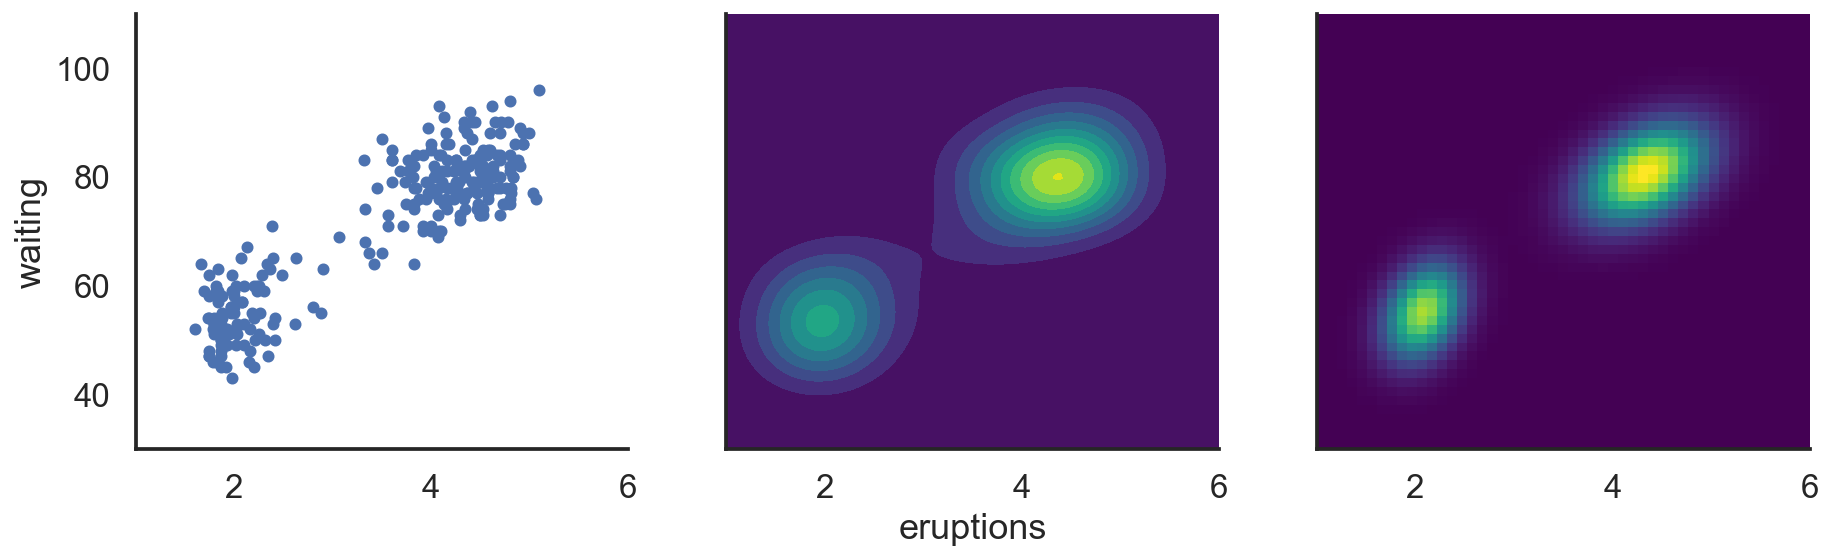

In [323]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

axes[0].scatter(X1, X2, marker='.')
sns.kdeplot(df, shade=True, cmap='viridis', gridsize=100, ax=axes[1])
axes[2].pcolormesh(erup_range, wait_range, density, cmap='viridis')

axes[1].set(xlabel='eruptions', xlim=(1, 6), ylim=(30, 110))
axes[0].set(ylabel='waiting')
sns.despine()

You can see how nicely the mixed model resembles the KDE model, but it has some advantages.

First, we have estimated the parameters, so we know what are the $\mu$ values, or the eruption and waiting means. We have two sets, one for each Gaussian.

[[ 4.28977944 79.96953298]
 [ 2.03652149 54.47986018]]


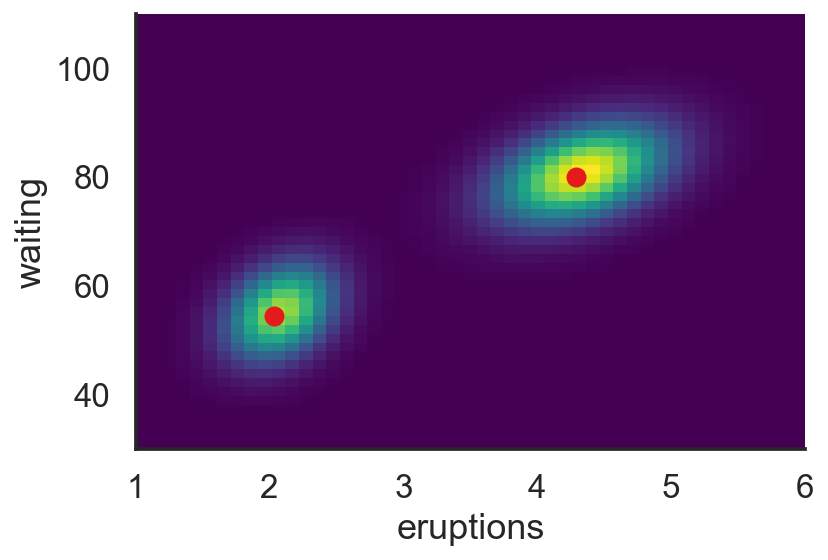

In [324]:
print(mixed.means_)

fig, ax = plt.subplots()
ax.pcolormesh(erup_range, wait_range, density, cmap='viridis')
ax.plot(*mixed.means_.T, 'o', color=red)
ax.set(xlabel='eruptions', xlim=(1, 6), ylim=(30, 110), ylabel='waiting')
sns.despine()

Second, we have also estimated the probabilities $p_1$ and $p_2$:

In [327]:
print('P(Zi=0)={:.2%}, P(Zi=1)={:.2%}'.format(*mixed.weights_))

P(Zi=0)=64.41%, P(Zi=1)=35.59%


Third, we can ask the mixed model to predict the latent variables $Z_i$ (or even the probability that $Z_i=1$ if using `predict_proba`.

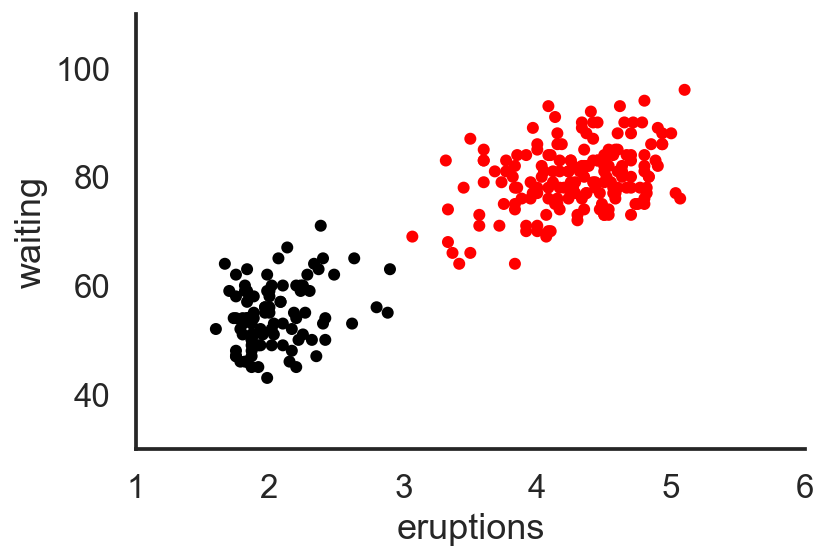

In [328]:
Z = mixed.predict(df)

fig, ax = plt.subplots()
ax.scatter(X1, X2, c=Z, marker='.', cmap='flag')
ax.set(xlabel='eruptions', xlim=(1, 6), ylim=(30, 110), ylabel='waiting')
sns.despine()

Essentially, we created a paramteric classifier! 

Not only this, you can see that it outperfoms a standard classifier such as KMeans.

In [280]:
from sklearn.cluster import KMeans

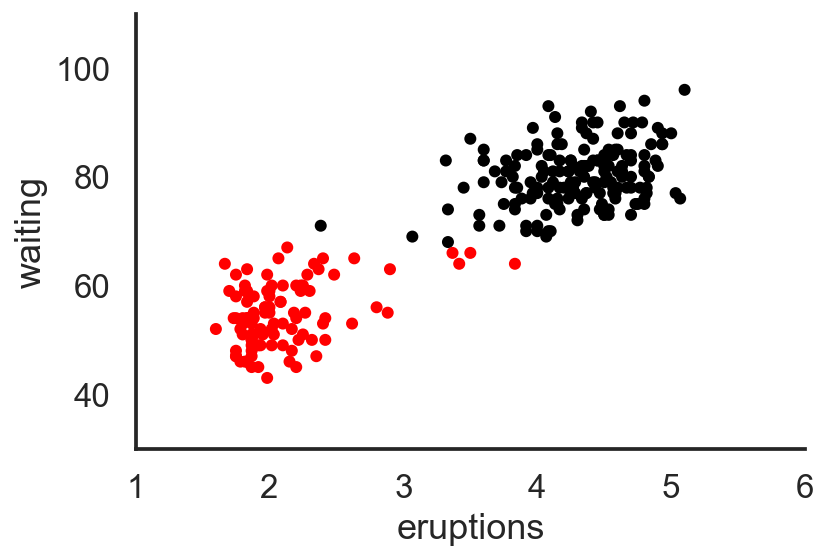

In [330]:
kmeans = KMeans(2)
cluster = kmeans.fit_predict(df)

fig, ax = plt.subplots()
ax.scatter(X1, X2, c=cluster, marker='.', cmap='flag')
ax.set(xlabel='eruptions', xlim=(1, 6), ylim=(30, 110), ylabel='waiting')
sns.despine()

Finally, we can also sample from the mixed model.

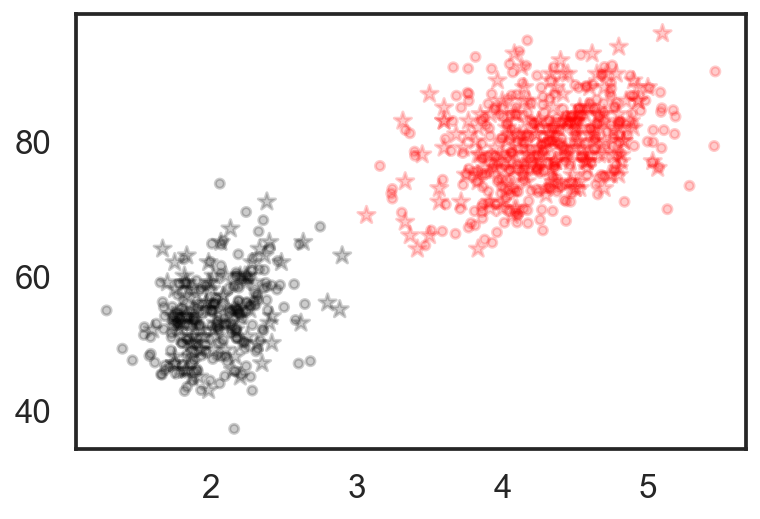

In [340]:
X_, Z_ = mixed.sample(500)
X1_, X2_ = X_[:,0], X_[:,1]

fig, ax = plt.subplots()
ax.scatter(X1, X2, c=Z, marker='*', alpha=0.2, cmap='flag')
ax.scatter(X1_, X2_, c=Z_, marker='.', alpha=0.2, cmap='flag')

# References

- [IPython Cookbook](http://ipython-books.github.io/cookbook/): IPython Interactive Computing and Visualization Cookbook by Cyrille Rossant.
- [scipy.stats tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
- [Scipy's statistical functions](http://docs.scipy.org/doc/scipy/reference/stats.html)
- [Visualizing distributions in Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html)
- [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) on Wikipedia
- [Density estimation in Scikit-learn](https://scikit-learn.org/stable/modules/density.html)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)